In [1]:
using CSV, DataFrames, Random, Statistics, Plots, XLSX


In [2]:
eez_codes = CSV.read("../data/eez_to_int.csv", DataFrame)
int_to_eez = Dict(zip(eez_codes.Int, eez_codes.EEZ))
eez_to_int = Dict(zip(eez_codes.EEZ, eez_codes.Int))

species_codes = CSV.read("../data/species_to_int.csv", DataFrame)
int_to_species = Dict(zip(species_codes.Int, species_codes.Species))

# read the eez_to_iso3 file
eez_to_iso3_data = CSV.read("../data/eez_to_iso3.csv", DataFrame)
eez_to_iso3 = Dict(zip(eez_to_iso3_data.Country, eez_to_iso3_data.ISO_3digit))
# read the economic data
economic_data = DataFrame(XLSX.readtable("../data/CLASS.xlsx", "List of economies"))


##
# Read the data, consisting on the newid, the species, the eez and the time spent in the eez    
agg_data = CSV.read("../data/agg_data.csv", DataFrame)

id_to_species_int = Dict(zip(agg_data.newid, agg_data.Species))
newids = unique(agg_data[:, :newid])
N = length(newids)
N_species = length(unique(agg_data[:, :Species]))

eezs = unique(agg_data[:, :EEZ])
iso3_eez = [eez_to_iso3[int_to_eez[eez]] for eez in eezs];



In [36]:
unique(agg_data, [:newid, :Species])

Row,newid,Species,EEZ,timestay (1/30days),timestay^2 (1/30days)
,Int64,Int64,Int64,Float64,Float64
1,0,0,8,30.0,900.0
2,1,0,8,30.0,900.0
3,2,0,8,30.0,900.0
4,3,0,8,30.0,900.0
5,4,0,8,30.0,900.0
6,5,0,8,30.0,900.0
7,6,0,8,30.0,900.0
8,7,0,8,30.0,900.0
9,8,0,8,30.0,900.0


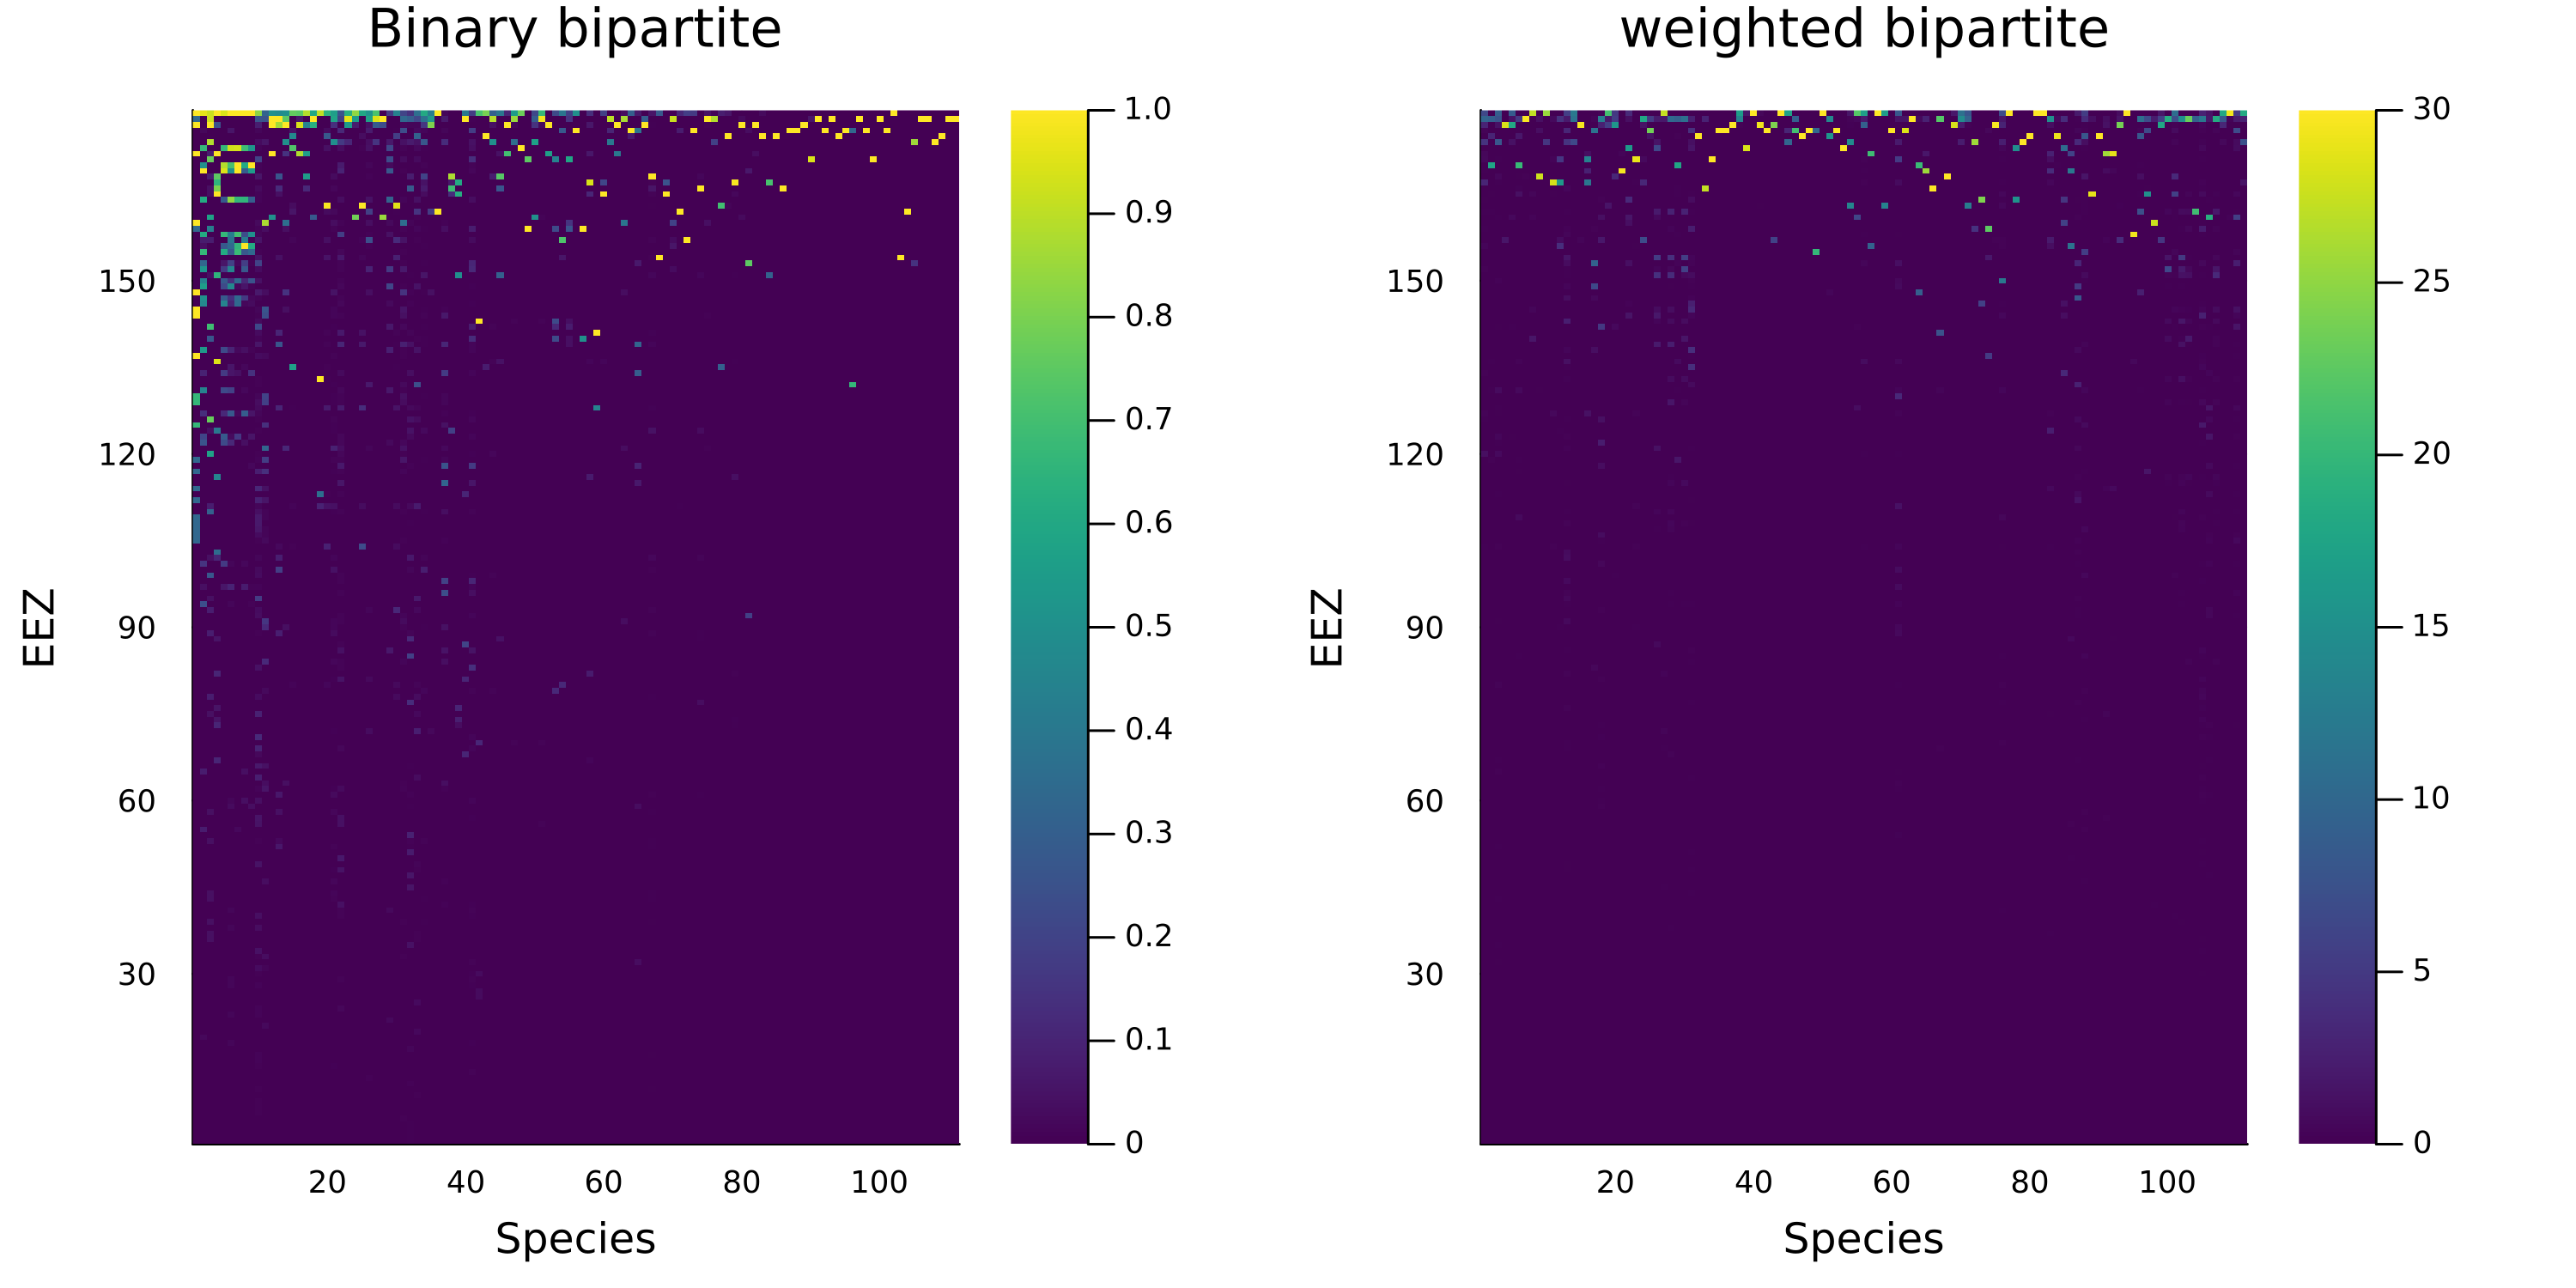

In [42]:
##

# construct a adjacency matrix of the bipartite graph
# taking the columns newid and EEZ as the nodes of the graph
# and the column "timestay (1/30days)" as the weight of the edges
# of the graph

M = Matrix{Float64}(undef, N_species, length(eezs))
M .= 0.
for row in eachrow(agg_data)
    M[species_codes.Int .== row.Species, eezs .== row.EEZ] .+= 1.# row["timestay (1/30days)"]
end

# normalize each row by the number of individuals of each species
Species_size = [sum(unique(agg_data, [:newid, :Species]).Species .== sp) for sp in unique(agg_data.Species)]

for i in 1:N_species
    M[i, :] ./= Species_size[i]
end
# sort the matrix so the rows are ordered by the sum of the elements of each row
# and the columns are ordered by the sum of the elements of each column
rows_sum = sum(M, dims=2)
cols_sum = sum(M, dims=1)

rows_order = sortperm(vec(rows_sum), rev=true)
cols_order = sortperm(vec(cols_sum), rev=false)

M = M[rows_order, cols_order]


##
p1 = heatmap(
    1:N_species,
    1:length(eezs),
    M',
    ylabel="EEZ",
    xlabel="Species",
    title="Binary bipartite", 
    color=cgrad(:viridis),
    size = (500,500)
    )

M = Matrix{Float64}(undef, N_species, length(eezs))
M .= 0.
for row in eachrow(agg_data)
    M[species_codes.Int .== row.Species, eezs .== row.EEZ] .+= row["timestay (1/30days)"]
end

# normalize each row by the number of individuals of each species
Species_size = [sum(unique(agg_data, [:newid, :Species]).Species .== sp) for sp in unique(agg_data.Species)]

for i in 1:N_species
    M[i, :] ./= Species_size[i]
end
# sort the matrix so the rows are ordered by the sum of the elements of each row
# and the columns are ordered by the sum of the elements of each column
rows_sum = sum(M, dims=2)
cols_sum = sum(M, dims=1)

rows_order = sortperm(vec(rows_sum), rev=true)
cols_order = sortperm(vec(cols_sum), rev=false)

M = M[rows_order, cols_order]


##
p2 = heatmap(
    1:N_species,
    1:length(eezs),
    M',
    ylabel="EEZ",
    xlabel="Species",
    title="weighted bipartite", 
    color=cgrad(:viridis),
    size = (500,500)
    # cscale=:log10
    )

plot(p1, p2, layout=(1, 2), size=(1000, 500), fmt=:png, dpi=300, margin=5Plots.mm)

In [43]:
sum(M, dims=2)

111×1 Matrix{Float64}:
 30.000000000000007
 30.000000000000007
 30.0
 30.000000000000007
 30.0
 30.000000000000004
 30.000000000000004
 30.0
 30.000000000000004
 30.0
  ⋮
 29.999999999999993
 29.999999999999993
 30.000000000000004
 30.000000000000004
 29.999999999999993
 29.999999999999993
 29.999999999999993
 30.0
 29.999999999999993

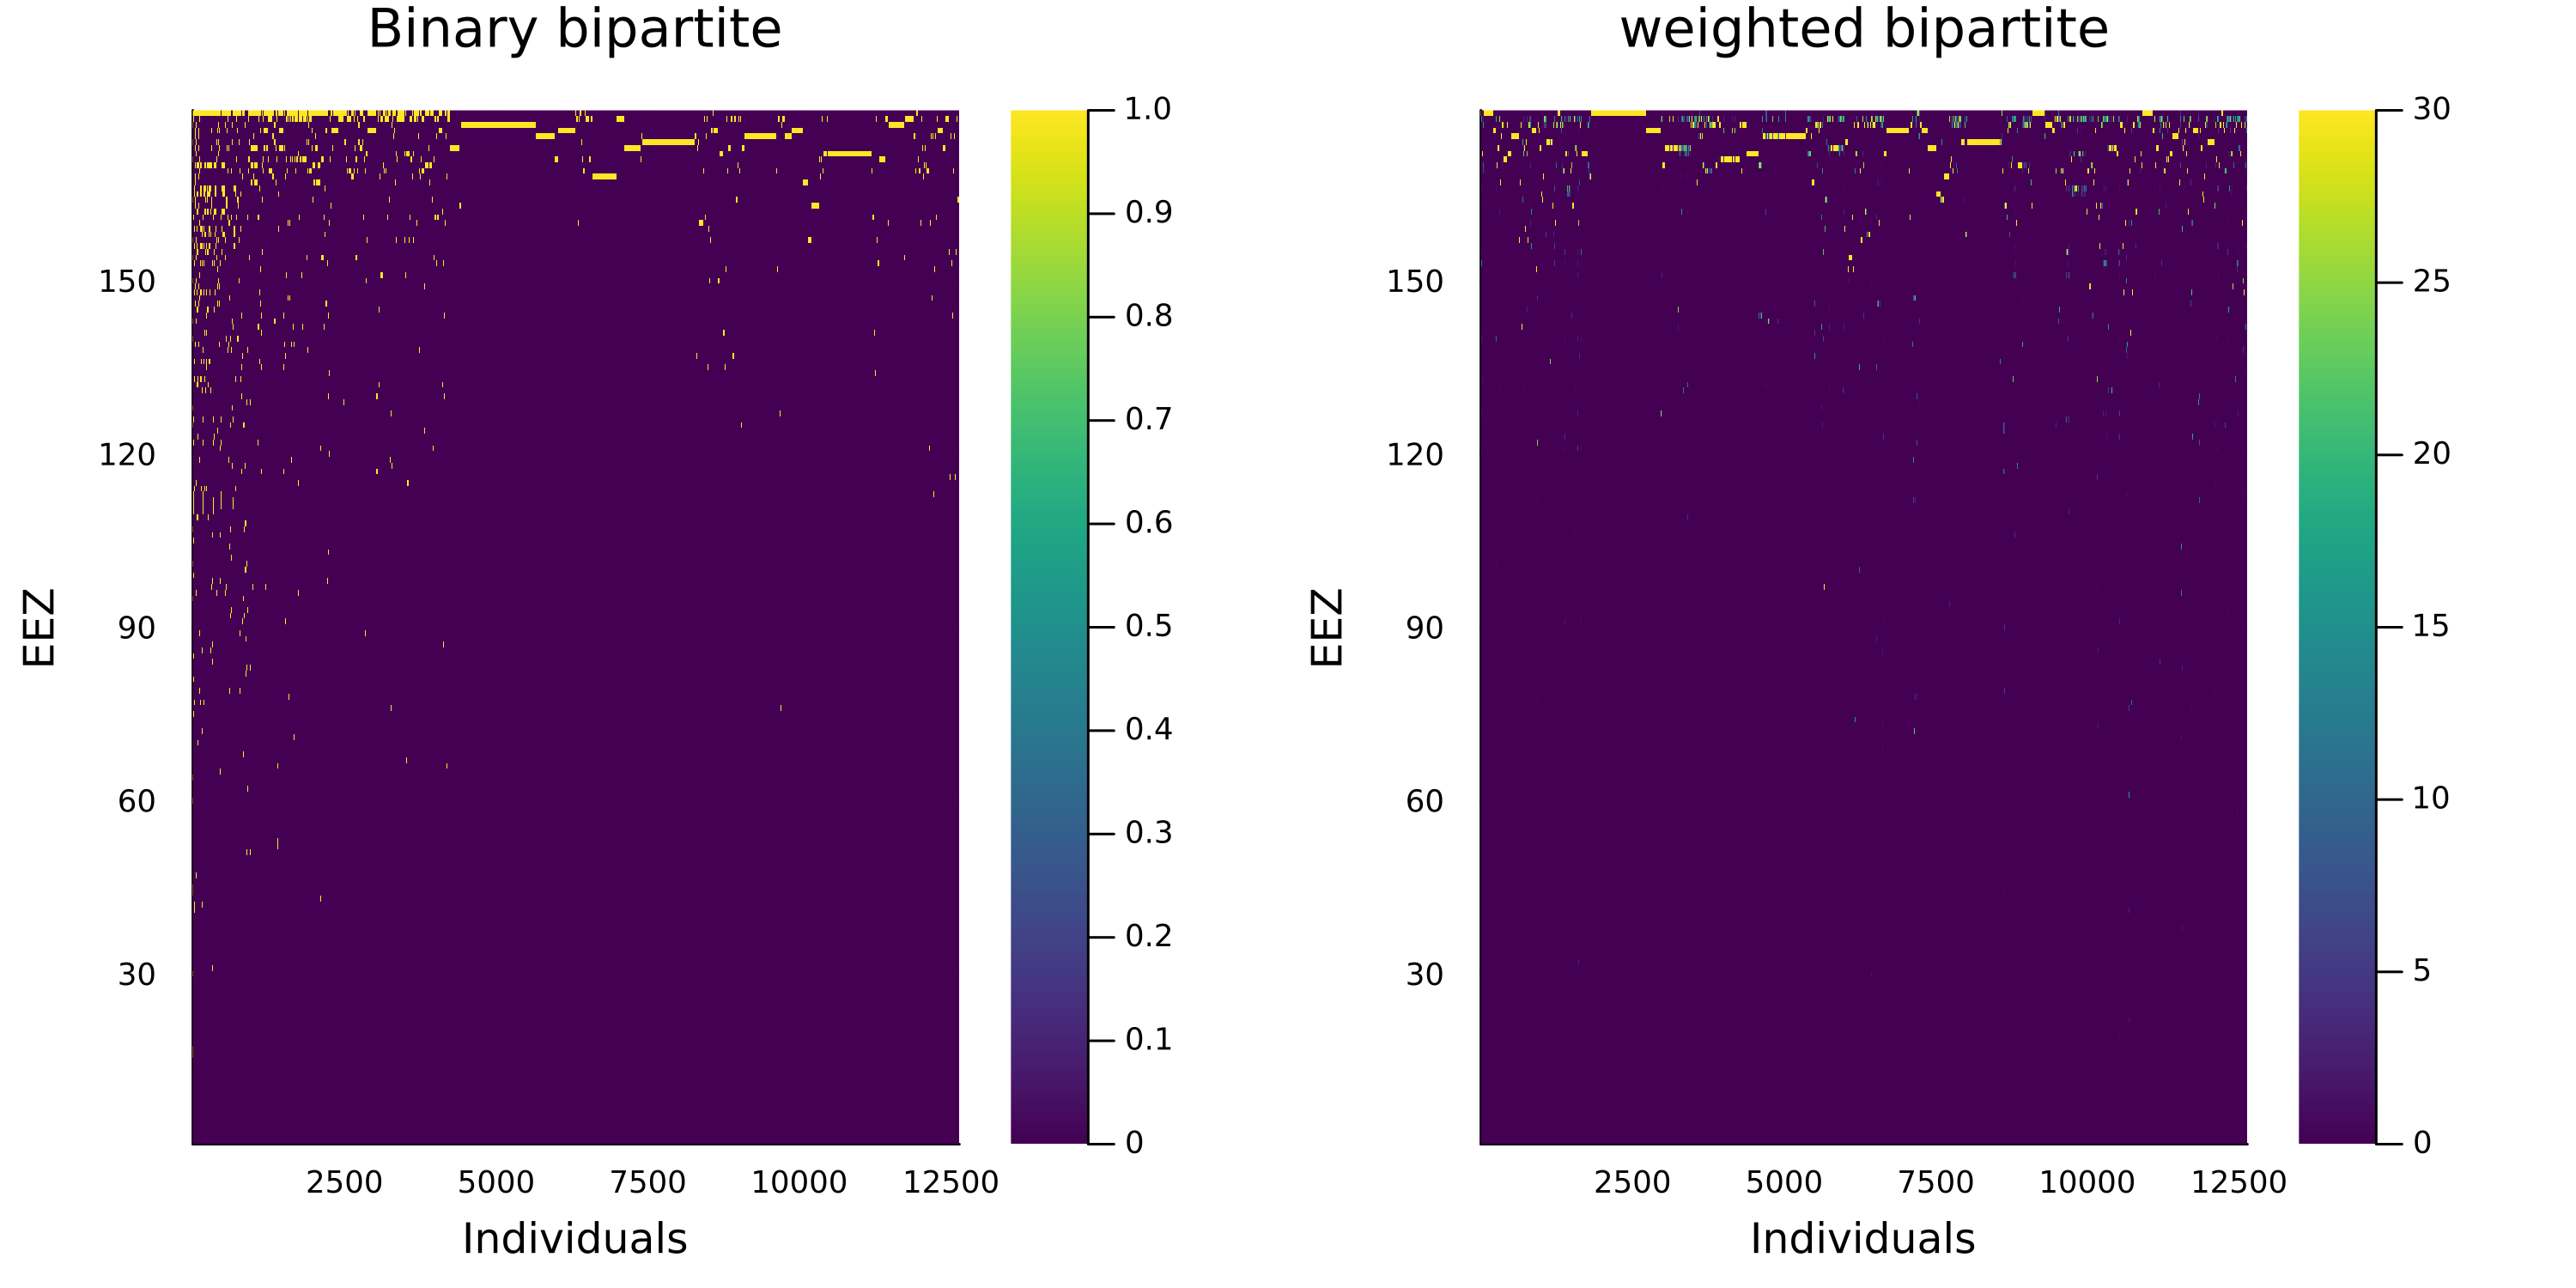

In [45]:

MM = Matrix{Float64}(undef, N, length(eezs))
MM .= 0.
for row in eachrow(agg_data)
    MM[newids .== row.newid, eezs .== row.EEZ] .+= 1. #row["timestay (1/30days)"]
end
rows_sum = sum(MM, dims=2)
cols_sum = sum(MM, dims=1)

rows_order = sortperm(vec(rows_sum), rev=true)
cols_order = sortperm(vec(cols_sum), rev=false)

MM = MM[rows_order, cols_order]




p1 = heatmap(MM', ylabel="EEZ", xlabel="Individuals", title="Binary bipartite", color=:viridis)#cgrad([:white, :orange]), size=(1000, 500))


MM = Matrix{Float64}(undef, N, length(eezs))
MM .= 0.
for row in eachrow(agg_data)
    MM[newids .== row.newid, eezs .== row.EEZ] .+= row["timestay (1/30days)"]
end
rows_sum = sum(MM, dims=2)
cols_sum = sum(MM, dims=1)

rows_order = sortperm(vec(rows_sum), rev=true)
cols_order = sortperm(vec(cols_sum), rev=false)

MM = MM[rows_order, cols_order]

p2 = heatmap(MM', ylabel="EEZ", xlabel="Individuals", title="Weighted matrix", color=:viridis)#cgrad([:white, :orange]), size=(1000, 500))

plot(p1, p2, layout=(1, 2), size=(1000, 500),fmt=:png, dpi=300, margin=5Plots.mm)

In [33]:
minimum(sum(MM, dims=2))

29.999999999999993